<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/checkpoints/02_kspace_classifier_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifying real images in kspace

- Can a CNN learn to classify given kspace as input?
- Can we apply audio (time freq) techniques to kspace (spacial freq)?
  - MELGAN, MEL Spectogram, MFCC (http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
  - Audio data augs

- Do max pooling layers help?

MRI scans have correct orientation; max pooling loses spacial info "ignores the relation between the part and the whole"
-- maybe try CNNs without max pooling?

![Max pooling, same features](https://miro.medium.com/max/1400/1*wsf4tsOH77T1lpylPUIhbA.png)

## Setup

In [1]:
PROJ       = "fastmri"

# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc
%run "$PROJ_PATH/01_kspace_tfms.ipynb" # get the kspace tfms

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


## Data

MNIST instead of Imagenet because MNIST, like MRI scans, have correct orientation.

In [2]:
url = URLs.MNIST # sizes = 28x28

# get folder path & files in folder
path = untar_data(url)
fnames = get_image_files(path)

# Transforms

In [0]:
# permute kspace tensor: N1HW(Complex) to N(Complex)HW
class Complex2Channel(Transform):
  order = 99 # happens after complex k

  # N1HW(Complex) -> N(Complex)HW
  def encodes(self, t:Tensor):
    if t.size(-1) == 2: return torch.squeeze(t.transpose(-1,-2).transpose(-2,-3))
    return t

  # NCHW -> NHWC
  def decodes(self, t:Tensor):
    if t.size(-3) == 2: return t.transpose(-3,-2).transpose(-2,-1)
    return t
    
# shows concat real & kspace into one image
class ShowK(Tuple):
  def show(self, ctx=None, **kwargs): 
    k,real = self
    line = k.new_zeros(k.shape[0], 10)
    return show_image(torch.cat([k,line,real], dim=1), title = "K & Real", ctx=ctx, **kwargs)

# take dataset item (real img, category), convert to (k arr, category)
class BatchReal2ComplexK(Transform):
  order = 13 # needs to run after save shape

  # do nothing to tensor categories
  def encodes(self, t:TensorCategory): return t
  def decodes(self, t:TensorCategory): return t

  def encodes(self, t:Tensor): return apply(t, TensorTfms.batch_real2k(onesided=False))


  def decodes(self, t_k:Tensor):
    t_k_abs         = apply(t_k, TensorTfms.t_abs)
    t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

    t_real     = apply(t_k, TensorTfms.batch_k2real(onesided=False))
    
    return ShowK(t_k_log_abs, t_real)

# converts complex k-space (2channel) to amplitude k-space (1channel)
class ComplexK2LogAbs(Transform):
  order = 14 # needs to run after Real2ComplexK

  # do nothing to tensor categories
  def encodes(self, t:TensorCategory): return t
  def decodes(self, t:TensorCategory): return t

  def encodes(self, t:Tensor): return apply(t, TensorTfms.log_abs, pre=TensorTfms.t_abs)

Test transforms

Selected fnames slice from 47541 to 47551
Batch of images: tensor of shape torch.Size([10, 28, 28])
Batch in kspace: tensor of shape torch.Size([10, 28, 28, 2])
Batch kspace2img: tensor of shape torch.Size([10, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([10, 28, 28])


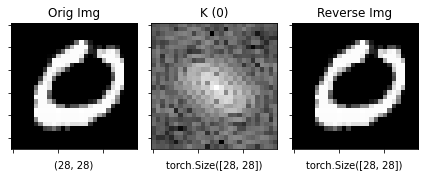

In [4]:
# select random slice of fnames
rand_idx = np.random.randint(0, len(fnames)-10)
bslice = slice(rand_idx,rand_idx+10)
print(f"Selected fnames slice from {rand_idx} to {rand_idx + 10}")

# get batch of images/labels
xb = [PILImageBW.create(fn) for fn in fnames[bslice]]
yb = [parent_label(fn) for fn in fnames[bslice]]

# im2tensor
t_xb = torch.stack(tuple(apply(x, TensorTfms.im2arr) for x in xb), dim=0)
print(f"Batch of images: tensor of shape {t_xb.shape}")

# im2kspace
k_xb = apply(t_xb, TensorTfms.real2k(onesided=False))
print(f"Batch in kspace: tensor of shape {k_xb.shape}")

# decodes
rev_xb = apply(k_xb, TensorTfms.k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_xb.shape}")

# kspace abs
k_abs_xb = apply(k_xb, TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {k_abs_xb.shape}")

# plot an item in xb
i = 1
plot([xb[i], k_abs_xb[i], rev_xb[i]], [f"Orig Img", f"K ({yb[i]})", f"Reverse Img"])

# Dataset

Audio Data augs? Normalize?


In [0]:
raw_items = fnames

x_tfms = [PILImageBW.create]
y_tfms = [parent_label, Categorize]

splitter  = GrandparentSplitter(train_name = "training", valid_name = "testing")
splits = splitter(raw_items)

#splitter = GrandparentSplitter(valid_name="val")
#splittter = RandomSplitter(valid_pct=0.2, seed=42)

dsets = Datasets(raw_items, tfms = [x_tfms, y_tfms], splits=splits)

((#10) ['0','1','2','3','4','5','6','7','8','9'],
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7fb1d7e978>)

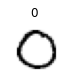

In [6]:
dsets.vocab, dsets.show(dsets[50000])

# Dataloaders

Define parameters

In [0]:
bs = 512
num_workers = 1

Define dataloaders (learning in image space)

In [0]:
item_tfms  = [ToTensor]
batch_tfms = [IntToFloatTensor] # Normalize? SaveShape

im_dls = dsets.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

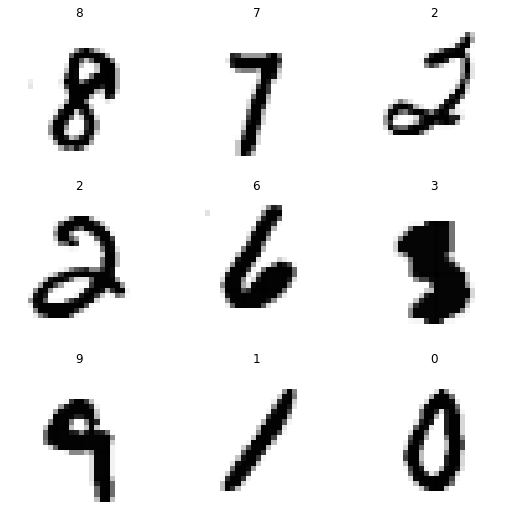

In [9]:
# viz
im_dls.show_batch()

Define dataloaders (learning in complex kspace)

In [0]:
k_item_tfms  = [ToTensor]
k_batch_tfms = [IntToFloatTensor, BatchReal2ComplexK, Complex2Channel] # Normalize? SaveShape

k_dls = dsets.dataloaders(
          after_item  = k_item_tfms, 
          after_batch = k_batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

Batch kspace2img: tensor of shape torch.Size([512, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([512, 28, 28])


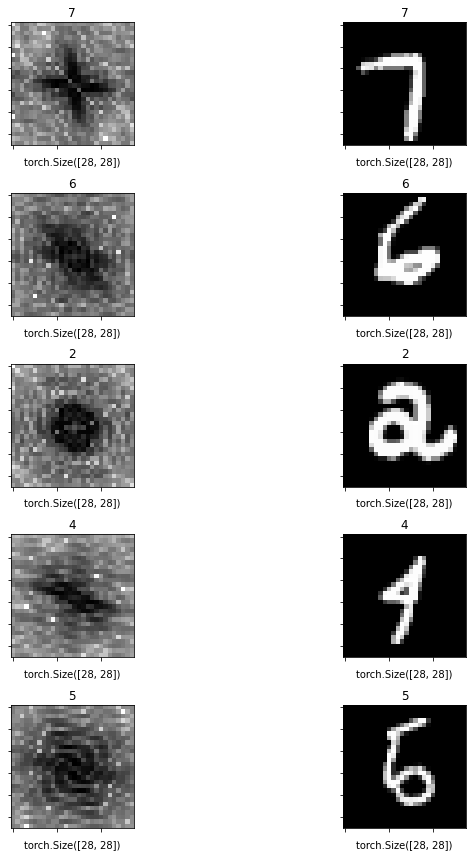

In [11]:
# viz

# get batch
k_xb, yb = k_dls.one_batch()
k_xb, yb = to_cpu(k_xb), to_cpu(yb)

# decodes
rev_k_xb = apply(Complex2Channel().decodes(k_xb), TensorTfms.batch_k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_k_xb.shape}")

# kspace abs
abs_k_xb = apply(Complex2Channel().decodes(k_xb), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_k_xb.shape}")

# plot item in batch

# select slice
nb = 5
bslice = slice(0,nb)

# set titles/order of images to plot
titles = [x for i in range(nb) for x in [f"{yb[i]}",  f"{yb[i]}"]]
imgs   = [x for i in range(nb) for x in [abs_k_xb[i], rev_k_xb[i]]]

# plot
plot(imgs, titles, nrows=nb, ncols=2, figsize=(12,12))

Define dataloaders (learning in log amp kspace)

In [0]:
k_abs_item_tfms  = [ToTensor]
k_abs_batch_tfms = [IntToFloatTensor, BatchReal2ComplexK, ComplexK2LogAbs] # Normalize? SaveShape

k_abs_dls = dsets.dataloaders(
          after_item  = k_abs_item_tfms, 
          after_batch = k_abs_batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

## print in a row

Batch of 10 digits in kspace (5 examples of each digit):
 tensor of shape torch.Size([50, 2, 28, 28])
Batch img (kspace to img): tensor of shape torch.Size([50, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([50, 28, 28])


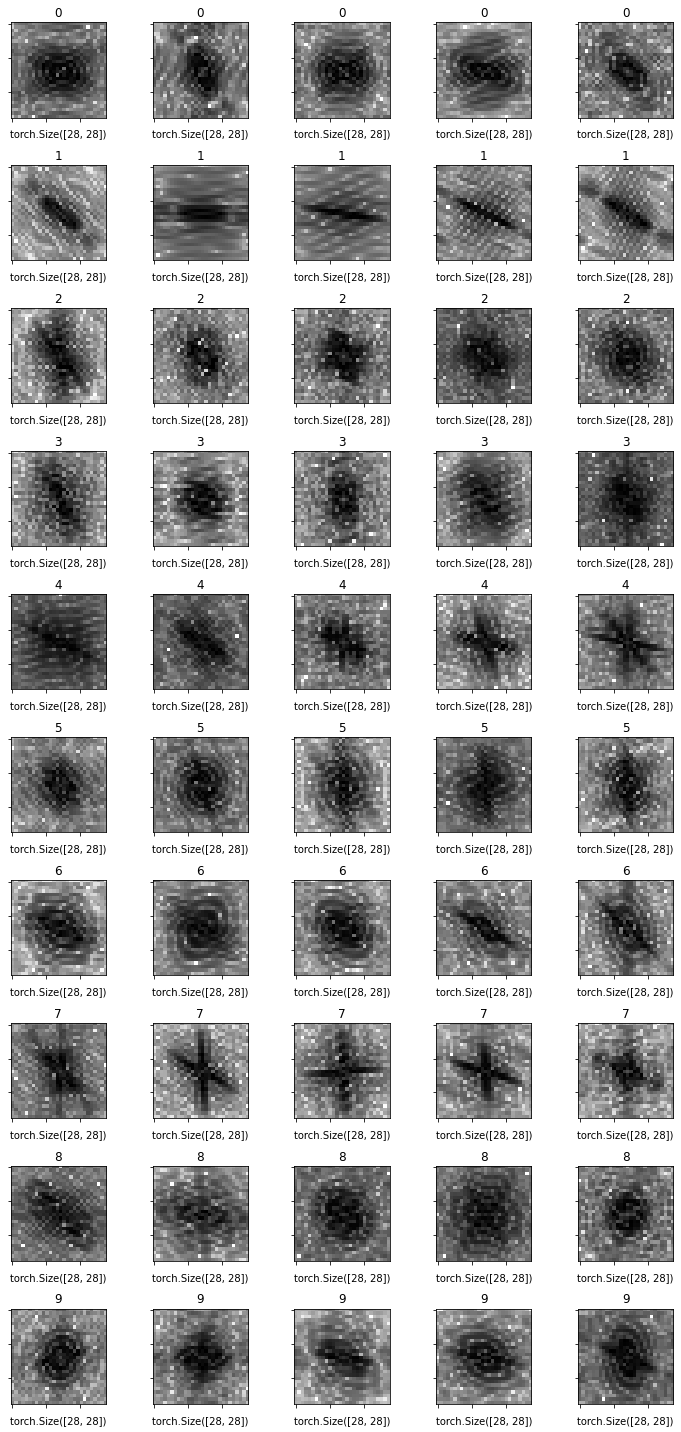

In [14]:
# set number of examples per row
ncols, nrows = 5, 10

# get random batch (512 bs)
kxb, yb = k_dls.one_batch()
kxb, yb = to_cpu(kxb), to_cpu(yb)

# grab 5 examples of each digit/category
kxbd = torch.cat(tuple(kxb[yb==digit][:ncols] for digit in range(10)), dim = 0)
ybd  = torch.cat(tuple(yb[yb==digit][:ncols] for digit in range(10)), dim = 0)
print(f"Batch of 10 digits in kspace ({ncols} examples of each digit):\n tensor of shape {kxbd.shape}")

# decodes
rev_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.batch_k2real(onesided=False))
print(f"Batch img (kspace to img): tensor of shape {rev_kxbd.shape}")

# kspace abs
abs_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_kxbd.shape}")

# plot item in batch

# set titles/order of images to plot
titles = [f"{ybd[i]}" for i in range(ncols*nrows)]
imgs   = [abs_kxbd[i] for i in range(ncols*nrows)]

# plot
plot(imgs, titles, nrows=nrows, ncols=ncols, figsize=(10,20))

Digit 9 batch: torch.Size([43, 2, 28, 28]), torch.Size([43])
Indices of 9 in batch: [ 11  15  23  40  43  62  79  95 109 120]
Batch kspace2img: tensor of shape torch.Size([43, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([43, 28, 28])


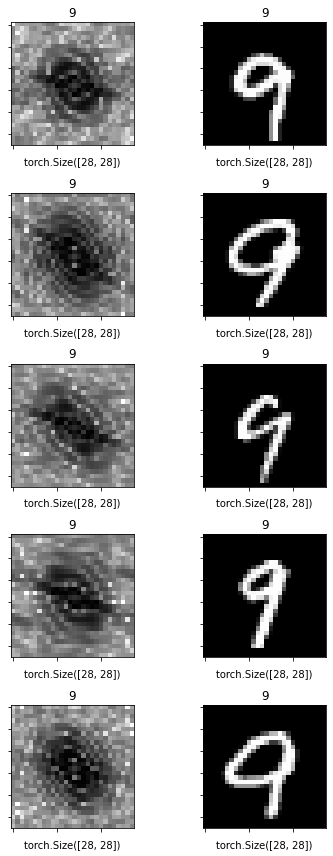

In [15]:
# screen for a particular digit

# get random batch (512 bs)
kxb, yb = k_dls.one_batch()
kxb, yb = to_cpu(kxb), to_cpu(yb)

# screen for digit
digit = 9

# x's,y's corresponding to digit 
kxbd = kxb[yb==digit] if digit != -1 else kxb
ybd  =  yb[yb==digit] if digit != -1 else kxb
print(f"Digit {digit} batch: {kxbd.shape}, {ybd.shape}")

# see idxs corresponding to digits
idxs = np.array(range(0, bs))[yb==digit]
print(f"Indices of {digit} in batch: {idxs[:10]}")

# decodes
rev_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.batch_k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_kxbd.shape}")

# kspace abs
abs_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_kxbd.shape}")

# plot item in batch

# select slice
nb = 5
bslice = slice(0,nb)

# set titles/order of images to plot
titles = [x for i in range(nb) for x in [f"{ybd[i]}",  f"{ybd[i]}"]]
imgs   = [x for i in range(nb) for x in [abs_kxbd[i], rev_kxbd[i]]]

# plot
plot(imgs, titles, nrows=nb, ncols=2, figsize=(6,12))

## Mean & STD 

(sparse k space though)

In [16]:
xb,yb = k_dls.one_batch()
xb,yb = to_cpu(xb), to_cpu(yb)
xb.shape, yb.shape

(torch.Size([512, 2, 28, 28]), torch.Size([512]))

Most of kspace has 0 amplitude/phase (sparse) -- not normally distributed

In [17]:
xb.mean(dim=[0,2,3]),xb.std(dim=[0,2,3])

(TensorImageBW([2.4222e-12, 3.4227e-11]), TensorImageBW([0.1661, 0.2837]))

## kspace2polar

perhaps easier for linear conv to pick up on important patterns

From SO: OpenCV 3.4 can do this now pretty easily with warpPolar()

In [0]:
def convert_to_polar():
  pass

# Architecture

Arch -- wave2letter Audio spectogram arch

CNN - Simple, no max pooling. Conv consists of 2dconv + batchnorm + activation ReLU.

In [0]:
# conv consists of 2dconv + batchnorm + activation ReLU
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [0]:
# assumes size is 28x28, 10 categories to predict
def get_simple_cnn(ni):
  return sequential(
    conv(ni,  8, ks=5),       # 14x14
    conv(8,  16),             # 7x7
    conv(16, 32),             # 4x4
    conv(32, 64),             # 2x2
    conv(64, 10, act=False),  # 1x10
    Flatten(),                # 10
)

In [0]:
simple_cnn   = get_simple_cnn(ni=1) # 1 input channel: black/white (k log abs)
k_simple_cnn = get_simple_cnn(ni=2) # complex kspace

Resnets

In [0]:
k_resnet   = xresnet18(c_in=2, n_out=10)
resnet     = xresnet18(c_in=1, n_out=10)

Test arch works

In [23]:
# all arch/dls
test_archs = [simple_cnn, resnet, k_simple_cnn, k_resnet]
test_dls   = [im_dls, k_dls, k_abs_dls]

# set arch/dl pair to test
arch_idx,dl_idx = 0,2

# test learning with given arch on given dls
arch,dls = test_archs[arch_idx], test_dls[dl_idx]
xb,yb = dls.one_batch()
xb,yb = to_cpu(xb), to_cpu(yb)
output = arch(xb)
print(f"input/output shape: {xb.shape}, {output.shape},\n output: {output[0]}")

input/output shape: torch.Size([512, 1, 28, 28]), torch.Size([512, 10]),
 output: tensor([ 1.2026, -0.9271,  0.3427, -0.8822, -1.0344,  0.3375,  2.0874, -0.3160,
         1.2642, -0.6169], grad_fn=<SelectBackward>)


# Learn

In [0]:
from fastai2.callback.hook import *

# set callbacks
cbs = ActivationStats(with_hist=True)

# get learner w/given arch + dls
def get_learner(dls, arch):
  return Learner(dls, arch, loss_func = F.cross_entropy, metrics=accuracy, cbs=cbs)

In [0]:
# learn in image space
learn_cnn    = get_learner(im_dls, simple_cnn)
learn_resnet = get_learner(im_dls, resnet)

# learn in k space
k_learn_cnn    = get_learner(k_dls, k_simple_cnn)
k_learn_resnet = get_learner(k_dls, k_resnet)

# learn in k_log_abs space (one-channel input so simple_cnn & resnet)
k_abs_learn_cnn    = get_learner(k_abs_dls, simple_cnn)
k_abs_learn_resnet = get_learner(k_abs_dls, resnet)

In [0]:
# learn.summary()

# Train

Baseline random: predict 1 out of 10 classes, expect 10% accuracy from random predictions.

Outcomes:

| Space     | Learner            | Accuracy | Time per Epoch | LR     | n_epoch | momentum |
|-----------|--------------------|----------|----------------|--------|---------|----------|
| image     | learn_cnn          | 93.74%   | 51sec               | 0.6    | 1       | 1cycle   |
| image     | learn_resnet       | 97.89%   | 1min 56sec               | 1.5e-2 | 1       | 1cycle   |
| complex k | k_learn_cnn        | 92.05%   | 51sec          | 0.33   | 1       | 1cycle   |
| complex k | k_learn_resnet     | 96.25%   | 55sec          | 5.3e-3 | 1       | 1cycle   |
| log abs k | k_abs_learn_cnn    | 63.71%   | 52sec          | 0.33   | 1       | 1cycle   |
| log abs k | k_abs_learn_resnet | 73.87%   | 1min 59sec     | 0.03   | 1       | 1cycle   |



- learn_cnn: learn.fit_one_cycle(n_epoch=1, lr=0.6), accuracy 93.74%
- learn_resnet: learn.fit_one_cycle(n_epoch=1, lr=1.5e-2), accuracy 97.89%

- k_learn_cnn, learn.fit_one_cycle(n_epoch=1, lr=0.33), accuracy 92.05% - time per epoch: 51sec
- k_learn_resnet, learn.fit_one_cycle(n_epoch=1, lr=5.3e-3), accuracy 96.25% - time per epoch: 55sec

- k_abs_learn_cnn, learn.fit_one_cycle(n_epoch=1, lr=0.33), accuracy 63.71% - time per epoch: 52sec
- k_abs_learn_resnet, learn.fit_one_cycle(n_epoch=1, lr=0.03), accuracy 73.87% - time per epoch: 1min 59sec

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.43651583790779114)

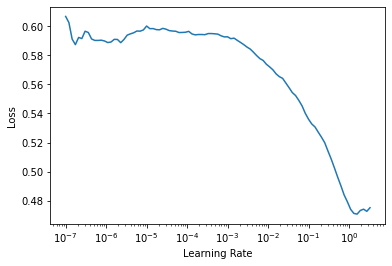

In [0]:
learn = k_learn_cnn
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=0.33)

epoch,train_loss,valid_loss,accuracy,time
0,0.452725,0.398170,0.955700,00:51


In [0]:
learn.fit_one_cycle(n_epoch=5, lr=0.1)

In [0]:
#learn.activation_stats.plot_layer_stats(-2)
#learn.activation_stats.plot_layer_stats(0)

# Old

In [0]:
# for Imagenette data

# convert filename stem to category
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

y_tfms = [parent_label, lbl_dict.__getitem__, Categorize]


In [0]:
# save original shape to IRFFT can umambiguously decode
class SaveShape(Transform):
  order = 12

  # excluding batch dimension
  def save_shape(t:Tensor):
    t.set_meta({"orig_shape": t.shape[-2:]})
    return t

In [0]:
# take dataset item (real img, category), convert to (k arr, category)
class Real2ComplexKOneSided(Transform):
  order = 13 # needs to run after save shape

  def encodes(self, t:Tensor): return apply(t, TensorTfms.real2k)


  def decodes(self, t_k:Tensor):
    t_k_abs         = apply(t_k, TensorTfms.t_abs)
    t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

    orig_shape = t_k.get_meta("orig_shape")
    t_real     = apply(t_k, TensorTfms.k2real(s=orig_shape))
    
    return ShowK(t_k_log_abs, t_real)

In [0]:
# k tensor that knows how to show itself
class K():
  def __init__(self, k, orig_shape):
    self.k, self.orig_shape = k, orig_shape

  def show(self, ctx=None, **kwargs): 
    rev_img = apply(self.k, TensorTfms.k2real(self.orig_shape))
    show_image(rev_img, cmap = "gray", title = "IRFFT", ctx=ctx, **kwargs)

  def to_tensor(self): return self.k

In [0]:
# convert original img arr to k space
class KTfm(Transform):
  
  # store orig shape so it can be decoded correctly (for showing purposes)
  def encodes(self, arr)->Tensor:
    return K(apply(arr, TensorTfms.real2k), arr.shape)

In [0]:
# permute tensor: HW(Complex) to (Complex)HW
class Permute(Transform):
  order = 1
  def encodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-3).transpose(-1,-2)
    return t

  def decodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-2).transpose(-1,-3)
    return t

## Old Viz

In [0]:
def k_show_batch(xb, yb, samples=None, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    
    t_k = Complex2Channel().decodes(xb)

    t_k_abs         = apply(t_k, TensorTfms.t_abs)
    t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

    orig_shape = xb[0].get_meta("orig_shape") # assume all shapes in batch equal
    t_real     = apply(t_k, TensorTfms.batch_k2real(onesided=False))
    
    if nrows is None: nrows = max_n//ncols

    if figsize is None: figsize = (ncols*6, 2 * nrows * 3)

    if ctxs is None: ctxs = get_grid(2*max_n, nrows=2*nrows, ncols=ncols, figsize=figsize)
    
    for i,ctx in enumerate(ctxs):
      row, col = i//ncols, i % ncols

      # odd rows show img in k space, even rows show img in real space
      arr     = t_k_log_abs if row%2 else t_real
      arr_idx = (row//2) * ncols + col
      
      im      = arr[arr_idx]    
      y       = yb[arr_idx]

      cmap = "gray_r" if row%2 else "gray"

      ctx.imshow(im, cmap=cmap)
      ctx.set_xticklabels([]), ctx.set_yticklabels([])
      ctx.set_title(f"{y}")
      #ctx.set_xlabel(tuple(im.shape))

In [0]:
# shows real & kspace together
class ShowK(Tuple):

  def show(self, ctx=None, **kwargs): 
    k,real = self
    line = k.new_zeros(k.shape[0], 10)
    return show_image(torch.cat([k,line,real], dim=1), title = "K & Real", ctx=ctx, **kwargs)

In [0]:
xb,yb = dls.one_batch()

In [0]:
xb.shape

In [0]:
t_k = tensor(xb[0])
t_k.shape

In [0]:
t_k = Complex2Channel().decodes(t_k)
t_k.shape

In [0]:
show_k = Real2ComplexK().decodes(t_k)
type(show_k)

In [0]:
show_k.show(figsize=(6,6), cmap="gray_r")